# German Traffic Sign Dataset

Third notebook of German Traffic dataset study. In this notebook, I will implement Data preprocessing techniques (Color space conversion, Data balancing, Data augmentation etc.). Also, I will implement more dense network than LeNet architecture and will try to increase the test accuracy.

In [8]:
import keras
import pickle
import cv2
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Dense,Dropout,Activation,Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
%matplotlib inline

# 1. Load Dataset

In [9]:
# Loading train and test dataset

with open('original_traffic_set/train.p',mode = 'rb') as f:
    train_data = pickle.load(f)
    
X_train,y_train = train_data['features'],train_data['labels']

with open('original_traffic_set/valid.p','rb') as ft:
    valid_data = pickle.load(ft)
    
X_valid,y_valid = valid_data['features'],valid_data['labels']

with open('original_traffic_set/test.p','rb') as ft:
    test_data = pickle.load(ft)
    
X_test,y_test = test_data['features'],test_data['labels']


# 2. Explore Dataset

In [10]:
print (X_train.shape,y_train.shape)
print (X_valid.shape,y_valid.shape)
print (X_test.shape,y_test.shape)

(34799, 32, 32, 3) (34799,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)


In [11]:
number_classes = len(np.unique(y_train))
unique_train, counts_train = np.unique(y_train, return_counts=True)

print ("Number of classes: ", unique_train)
print ()
print ("Counts in each class: ", counts_train)

Number of classes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]

Counts in each class:  [ 180 1980 2010 1260 1770 1650  360 1290 1260 1320 1800 1170 1890 1920
  690  540  360  990 1080  180  300  270  330  450  240 1350  540  210
  480  240  390  690  210  599  360 1080  330  180 1860  270  300  210
  210]


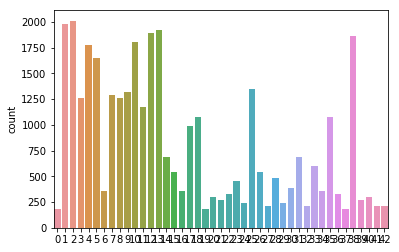

In [12]:
sns.countplot(y_train,label="Count")
plt.show()

## Observations
    1. Dataset has around ~35k train images with 43 classes
    2. From above figure, we can say that dataset is unbalanced with lowest class value 180 and highest 2010. We have to balance these data.
    

## Visulizing train images with labels

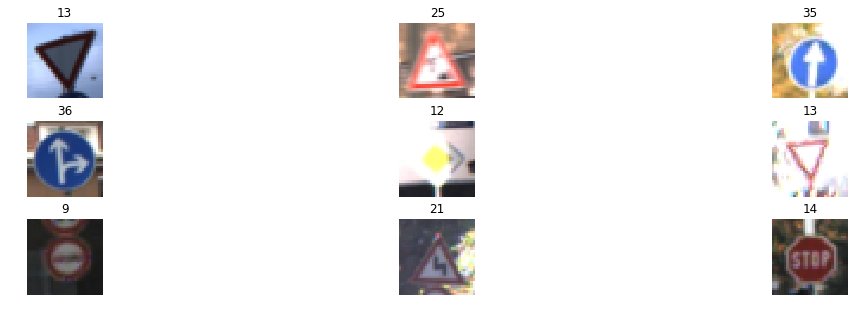

In [13]:
import random
fig,axs = plt.subplots(3,3,figsize=(20,5))
fig.subplots_adjust(hspace = .3,wspace=.005)
axs = axs.ravel()

for i in range(9):
    index = random.randint(0,len(X_train))
    img = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(img)
    axs[i].set_title(y_train[index])

# 3. Data Pre processing

Here we have seen that our data is highly unbalanced, so first we have to balance the dataset. For that, I will **augment** the data. Augmentation can be done with two different approach. First is to use Keras' library ImageDataGenerator class and generate augmentation images on a flow (In-time) so that we load only few images into RAM but this will increase the time in training. And actually it is increasing training time a lot. (I have CPU!!!). Second approach is to create augmented data manually and train the model. Here I am using the later approach.

Second, I will try different color space and decide according to the performance. For now, I have following ideas regarding color space in my mind.
        1. Use RGB as it is.
        2. Use only Grayscale. We can reduce the parameters by using grayscale. Also, for traffic sign classification problem, grayscale images should work good.
        3. RGB + Grayscale images. (Convert RGB to grayscale and then concatenate with RGB channel)
        4. HSV colorspace
        



In [20]:
#Preprocess Data

def normalize_data(data):
    
    normal = data/255.0 - 0.5
    return normal

#Dot method to convert image from RGB to GRAY. Faster method than
#Opencv cvtColor method.
def rgb2gray(data):
    gray = np.dot(data[...,:3],[0.299,0.587,0.114])
    return gray


#Augmented Functions
#CAUTION : The most common augmentation functions are vertical
#and horizontal flips. Both are not useful for our case. 
#We have left turn /right turn images which are mirror images to
#each other. Also we want to read some speed limits so horizontal
#flips are not useful either.

#We can use translation, "MINOR" rotation, Blurring etc.
#Here I am using minor rotation, Affine transformation and Gaussian
#Blurring.

def rotation_minor(img):
    rows,cols,channel = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),15,1)
    rot = cv2.warpAffine(img,M,(cols,rows))
    return rot

def affine_transform(img):
    rows,cols,channel = img.shape
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pts2 = np.float32([[1,10],[20,5],[10,25]])

    M = cv2.getAffineTransform(pts1,pts2)

    aff = cv2.warpAffine(img,M,(cols,rows))
    return aff

def gaussian_bluring(img):
    gauss_blur = cv2.GaussianBlur(img,(5,5),0)
    return gauss_blur



In [16]:
X_train_gray = rgb2gray(X_train)
X_valid_gray = rgb2gray(X_valid)
X_test_gray = rgb2gray(X_test)

X_train_normalized = normalize_data(X_train_gray)
X_valid_normalized = normalize_data(X_valid_gray)
X_test_normalized = normalize_data(X_test_gray)

print (X_train_normalized.shape)
print (X_valid_normalized.shape)
print (X_test_normalized.shape)

(34799, 32, 32)
(4410, 32, 32)
(12630, 32, 32)


In [17]:
#We need channel in shape too!
X_train_normalized = np.reshape(X_train_normalized,[-1,32,32,1])
X_valid_normalized = np.reshape(X_valid_normalized,[-1,32,32,1])
X_test_normalized = np.reshape(X_test_normalized,[-1,32,32,1])
print (X_train_normalized.shape)
print (X_valid_normalized.shape)
print (X_test_normalized.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


Above block converts the X_train,X_valid and X_test from 32x32 to 32x32x1 data. Also, we can confirm that the X_train data is now normalized i.e. mean value is -0.17(~0) and no values are < -0.5 or > 0.5

In [18]:

print (X_train_normalized.mean())
print ((X_train_normalized < -0.5).any())

-0.17875894926010927
False


Now I have to create data augmentation. We know that our data is unbalanced. So, my logic is to create augmented images for only those classes who has less images. This way I am increasing the total number of examples and balancing the data.

**Logic :** 

Loop over the classes.

If num_images < threshold value then augment images.

Append images and related label

Make new numpy arrays of images and labels

In [34]:
index = np.where(y_train == 0)
#print (index)
print (index)

(array([ 9960,  9961,  9962,  9963,  9964,  9965,  9966,  9967,  9968,
        9969,  9970,  9971,  9972,  9973,  9974,  9975,  9976,  9977,
        9978,  9979,  9980,  9981,  9982,  9983,  9984,  9985,  9986,
        9987,  9988,  9989,  9990,  9991,  9992,  9993,  9994,  9995,
        9996,  9997,  9998,  9999, 10000, 10001, 10002, 10003, 10004,
       10005, 10006, 10007, 10008, 10009, 10010, 10011, 10012, 10013,
       10014, 10015, 10016, 10017, 10018, 10019, 10020, 10021, 10022,
       10023, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031,
       10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 10040,
       10041, 10042, 10043, 10044, 10045, 10046, 10047, 10048, 10049,
       10050, 10051, 10052, 10053, 10054, 10055, 10056, 10057, 10058,
       10059, 10060, 10061, 10062, 10063, 10064, 10065, 10066, 10067,
       10068, 10069, 10070, 10071, 10072, 10073, 10074, 10075, 10076,
       10077, 10078, 10079, 10080, 10081, 10082, 10083, 10084, 10085,
       10086, 10087

In [25]:
X_train_augmented = X_train_normalized
y_train_augmented = y_train

print (X_train_augmented.shape)
print (y_train_augmented.shape)

(34799, 32, 32, 1)
(34799,)


In [35]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
for class_index,class_counts in zip(unique_train,counts_train):
    if class_counts < 800:
        #print (class_index,class_counts)
        for i in range(class_counts):
            index_of_images_in_this_class = np.where(y_train == class_index)
            
            new_image_1 = affine_transform(X_train_normalized[index_of_images_in_this_class[0][i]])
            new_image_2 = rotation_minor(X_train_normalized[index_of_images_in_this_class[0][i]])
            new_image_3 = gaussian_bluring(X_train_normalized[index_of_images_in_this_class[0][i]])
            
            new_image_1 = np.reshape(new_image_1,[-1,32,32,1])
            new_image_2 = np.reshape(new_image_2,[-1,32,32,1])
            new_image_3 = np.reshape(new_image_3,[-1,32,32,1])
            
            X_train_augmented = np.concatenate((X_train_augmented, new_image_1), axis=0)
            y_train_augmented = np.concatenate((y_train_augmented,[class_index]),axis=0)
            X_train_augmented = np.concatenate((X_train_augmented, new_image_2), axis=0)
            y_train_augmented = np.concatenate((y_train_augmented,[class_index]),axis=0)
            X_train_augmented = np.concatenate((X_train_augmented, new_image_3), axis=0)
            y_train_augmented = np.concatenate((y_train_augmented,[class_index]),axis=0)
            

print (X_train_augmented.shape)
print (y_train_augmented.shape)       

(62156, 32, 32, 1)
(62156,)


Phew!! It took quite a longggggg!!!
But we have now ~62K train images. Almost double.


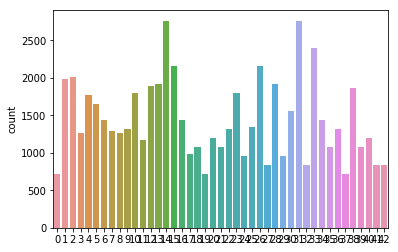

In [36]:
#Let's look at augmented data class distribution
sns.countplot(y_train_augmented,label="Count")
plt.show()

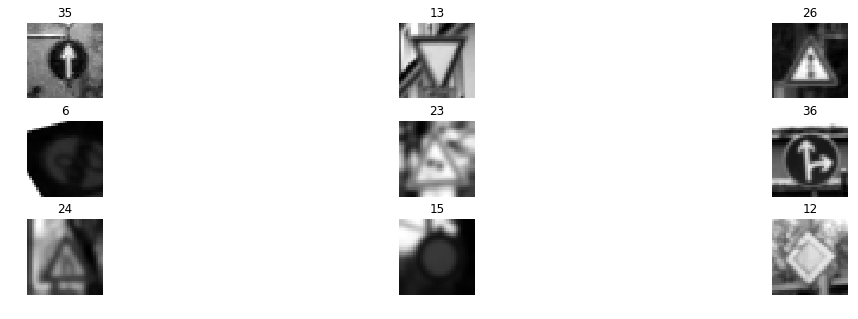

In [40]:
#Visualize images with labels just to confirm that our augmented data are correct
import random
fig,axs = plt.subplots(3,3,figsize=(20,5))
fig.subplots_adjust(hspace = .3,wspace=.005)
axs = axs.ravel()

for i in range(9):
    index = random.randint(0,len(X_train_augmented))
    img = X_train_augmented[index].squeeze()
    axs[i].axis('off')
    axs[i].imshow(img,cmap='gray')
    axs[i].set_title(y_train_augmented[index])

Each class has now at least 500 images which is reasonable and we can train on deeper network now.

In [47]:
labelbinarizer = LabelBinarizer()
y_train_one_hot = labelbinarizer.fit_transform(y_train_augmented)
y_valid_one_hot = labelbinarizer.fit_transform(y_valid)

print (X_train_augmented.shape)
print (X_valid_normalized.shape)
print (y_train_one_hot.shape)
print (y_valid_one_hot.shape)

(62156, 32, 32, 1)
(4410, 32, 32, 1)
(62156, 43)
(4410, 43)


# 3. Define Model

In this notebook, I have implemented more complex model than LeNet which is based on VGGNet.

![VggNet Architecture](vggnet.jpg)
![VggNet Model](vggnet_model.png)

In [54]:
model = Sequential()

#Layer1
model.add(Conv2D(32,3,padding="same",input_shape=(32,32,1)))
model.add(Activation('relu'))

#Layer2
model.add(Conv2D(32,3,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

#Layer3
model.add(Conv2D(64,3,padding="same"))
model.add(Activation('relu'))

#Layer4
model.add(Conv2D(64,3,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

#Layer5
model.add(Conv2D(128,3,padding="same"))
model.add(Activation('relu'))

#Layer6
model.add(Conv2D(128,3,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))
#Flatten
model.add(Flatten())

#FC1
model.add(Dense(120))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#FC2
model.add(Dense(120))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#Output
model.add(Dense(number_classes))
model.add(Activation('softmax'))

In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_20 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        18496     
__________

In [56]:
model.compile(keras.optimizers.Adam(lr=0.0009), 'categorical_crossentropy', ['accuracy'])

In [57]:


history = model.fit(X_train_augmented, y_train_one_hot, nb_epoch=30,batch_size=64,validation_data=(X_valid_normalized,y_valid_one_hot))

/Users/kathan/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 62156 samples, validate on 4410 samples
Epoch 1/30
62156/62156 [==============================] - 306s 5ms/step - loss: 2.7007 - acc: 0.2479 - val_loss: 0.9022 - val_acc: 0.7388
Epoch 2/30
62156/62156 [==============================] - 311s 5ms/step - loss: 0.9214 - acc: 0.6968 - val_loss: 0.2229 - val_acc: 0.9252
Epoch 3/30
62156/62156 [==============================] - 442s 7ms/step - loss: 0.4657 - acc: 0.8506 - val_loss: 0.1364 - val_acc: 0.9615
Epoch 4/30
62156/62156 [==============================] - 522s 8ms/step - loss: 0.3118 - acc: 0.9032 - val_loss: 0.0864 - val_acc: 0.9778
Epoch 5/30
62156/62156 [==============================] - 554s 9ms/step - loss: 0.2326 - acc: 0.9306 - val_loss: 0.0612 - val_acc: 0.9816
Epoch 6/30
62156/62156 [==============================] - 621s 10ms/step - loss: 0.1909 - acc: 0.9424 - val_loss: 0.0731 - val_acc: 0.9828
Epoch 7/30
62156/62156 [==============================] - 620s 10ms/step - loss: 0.1663 - acc: 0.9520 - val_loss: 0.0634 -

dict_keys(['loss', 'val_acc', 'acc', 'val_loss'])


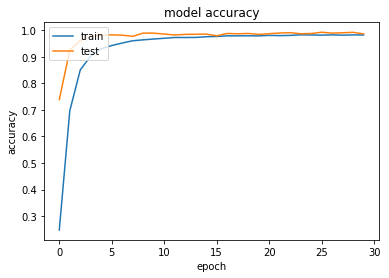

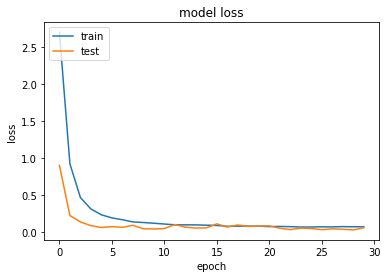

In [58]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
model.save('German_Traffic_VGGNET_Trial1.h5')

In [60]:
print (X_test_normalized.shape)
print (y_test.shape)
y_test_one_hot = labelbinarizer.fit_transform(y_test)
score, acc = model.evaluate(X_test_normalized, y_test_one_hot,
                            batch_size=32)
acc = acc * 100.0
print('Test score:', score)
print('Test accuracy:', acc)

(12630, 32, 32, 1)
(12630,)
12630/12630 [==============================] - 21s 2ms/step
Test score: 0.12935912365215865
Test accuracy: 97.43467933963615


# 4. Conclusion

In this notebook, I have implemented VGGNet basedarchitecture and trained the model on 30 epochs we are getting ~97.43% accuracy on test data with this setting.

